<a href="https://colab.research.google.com/github/emnordi/ce888/blob/master/Lab8/Exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/sagihaider/CE888_2020.git

fatal: destination path 'CE888_2020' already exists and is not an empty directory.


In [0]:
import os
import shutil
from keras import layers
from keras import models
from keras import optimizers
from zipfile import ZipFile
from keras.preprocessing.image import ImageDataGenerator
os.environ['KAGGLE_USERNAME'] = "emilnordin" # username from the json file
os.environ['KAGGLE_KEY'] = "fd1ae7405c909d36a1ecffea5cd2749a" # key from the json file

In [0]:
# Upload data
from zipfile import ZipFile
file_name = "/content/CE888_2020/Lab_8/data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [0]:
#Download fruit detection dataset
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection # api copied from kaggle

 88% 25.0M/28.4M [00:01<00:00, 12.4MB/s]
100% 28.4M/28.4M [00:01<00:00, 24.5MB/s]


In [0]:
#Extract fruit detection
file_name = "/content/fruit-images-for-object-detection.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


Install packages tensorflow 1.3.0 and keras 2.0.7

In [0]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

In [0]:
import numpy as np
import os
import time
from CE888_2020.Lab_8.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [0]:
#%% Load an elephant image as an example and see the image-processing

img_path = '/content/train_zip/train/apple_1.jpg' # image name
img = image.load_img(img_path, target_size=(224, 224)) # load image
x = image.img_to_array(img) # convert image to array
print (x.shape)
x = np.expand_dims(x, axis=0) # expand dimension
print (x.shape)
x = preprocess_input(x)
print('Input image shape:', x.shape)

(224, 224, 3)
(1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)


In [0]:
#%% Loading the training data
PATH = os.getcwd()
# Define data path
data_path = PATH + '/train_zip'
data_dir_list = os.listdir(data_path)

In [0]:
img_data_list=[] # created an empty list for images to be loaded
for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		if img.endswith((".jpg")):
			img_path = data_path + '/'+ dataset + '/'+ img
			img = image.load_img(img_path, target_size=(224, 224))
			x = image.img_to_array(img)
			x = np.expand_dims(x, axis=0)
			x = preprocess_input(x)
#			x = x/255
			# print('Input image shape:', x.shape)
			img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-train



/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(240, 1, 224, 224, 3)
(1, 240, 224, 224, 3)
(240, 224, 224, 3)


In [0]:
apples = 0
bananas = 0
mixed = 0
oranges = 0

for dataset in data_dir_list:
  img_list=os.listdir(data_path+'/'+ dataset)
  print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
  for img in img_list:
    if img.endswith((".jpg")):
      if "apple" in img:
        apples += 1
      elif "banana" in img:
        bananas += 1
      elif "mixed" in img:
        mixed += 1
      elif "orange" in img:
        oranges +=1  

print(apples, "Apples")
print(bananas, "bananas")
print(mixed, "mixed")
print(oranges, "oranges")
print(apples+bananas+mixed+oranges, "Total")

Loaded the images of dataset-train

75 Apples
73 bananas
20 mixed
72 oranges
240 Total


In [0]:
# Define the number of classes
num_classes = 4
print(img_data.shape[0])
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:74]=0
labels[75:147]=1
labels[148:167]=2
labels[168:]=3

names = ['apple','banana', 'mixed', 'orange']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


240


In [0]:
image_input = Input(shape=(224, 224, 3)) # shape of a single image

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet') # load VGG-16 model with 'top = true'
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

custom_vgg_model.layers[3].trainable
custom_vgg_model.summary()

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
t=time.time()
#	t = now()
hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 192 samples, validate on 48 samples
Epoch 1/2
192/192 [==============================] - 360s - loss: 3.4111 - acc: 0.2396 - val_loss: 1.9844 - val_acc: 0.3958
Epoch 2/2
192/192 [==============================] - 364s - loss: 1.4439 - acc: 0.4688 - val_loss: 1.7022 - val_acc: 0.3750
Training time: -725.1735243797302
48/48 [==============================] - 74s     
[INFO] loss=1.7022, accuracy: 37.5000%


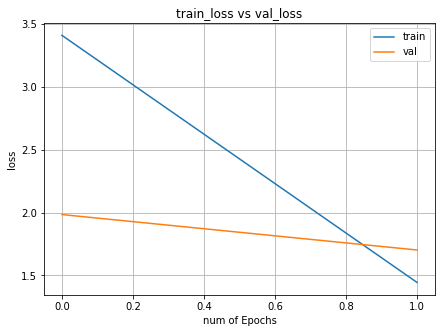

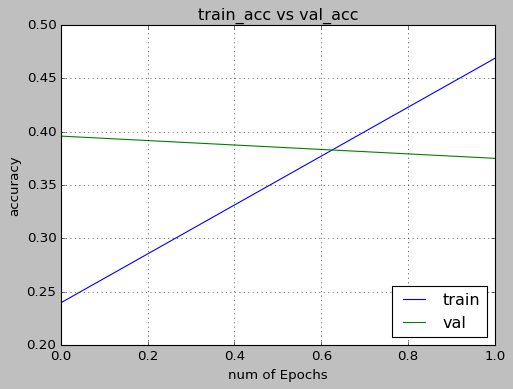

In [0]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(2)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])